# Inhibitor Diffusion and Germination - Slow Release

## Numerical experiments - Week 45/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32

## 1. General assumptions

Medium and conidium sizes:
- See Experiment 01.

Concentrations:
- See Experiment 01.

Membrane permeability
- The spore is assumed to have a lipid bilayer membrane with narrow channels which mediate the release of inhibitor.

## 2. Mathematical framework

### 2.1 Permeation constant

To model the pemeability of the spore membrane, one must consider the flux through a one-dimensional capillary tube, defined as

$$
J_s=-P_s\nabla c,
$$

where $P_s$ is a permeation constant depending both on the membrane and the permeating molecule. For the diffusion of glucose across an artificial lipid bilayer membrane, $P_s\approx 10^{-3}\mu\textrm{m/s}$[2].

To incorporate this parameter into the diffusion model, its relationship to a diffusion constant needs to be determined. Some sources[1] define this relationship as

$$
P_s = \frac{K}{d}D_m,
$$

where $d$ is the membrane thickness, $K$ is the oil/water partition coefficient and $D_m$ is the solute's diffusion coefficient in the membrane material. According to this formulation, the diffusion constant can be expressed as:

$$
D_m =\frac{d}{K}P_s
$$

The octanol-water partition coefficient for glucose ($K\approx 10^-3$)[3] can be used as a characteristic value for $K$. As a reference number for $d$, the cell wall thickness of _Aspergillus sydowii_ can be used[5]: $d\approx 140\textrm{nm}=0.14\mu\textrm{m}$. Substituting these values results in $D_m=\frac{0.14\mu\textrm{m}\times 10^{-3}\mu\textrm{m/s}}{10^{-3}}=0.14\mu\textrm{m}^2/\textrm{s}$.

Considering the interpretation of $P_s$ as the permeation constant through a narrow channel of the membrane, an alternative formulation can also be used[2]:

$$
P_s = \frac{\alpha}{d}D_m
$$

The formulation is related to the length of this channel ($d$, equivalent to the membrane thickness) and the fraction $\alpha$ of the cell surface taken up by channels. The above equation can be rewritten for $D_m$:

$$
D_m = \frac{d}{\alpha}P_s
$$

Glucose is a relatively large molecule, which cannot easily pass through the hydrophobic core of a membrane and is generally facilitated by glucose transporters (GLUT proteins). It is estimated that such proteins may cover about 4\% of the membrane area in yeasts[4]. Hence, a value of $\alpha=0.04$ will be used in the current experiment.

Under these assumptions, the diffusion constant for the membrane transport can be set to $D_m=\frac{0.14\mu\textrm{m}\times 10^{-3}\mu\textrm{m/s}}{0.04}=3.5\times10^{-3}\mu\textrm{m}^2/\textrm{s}$

### 2.2. Modified diffusion equation and discretisation

The standard flux equation from Fick's Law for diffusion in a fluid medium is defined as follows:

$$
J=-D\nabla c\tag{1}
$$

The resulting coefficient $D_m$ can be used in a similar way for a flux through a membrane:

$$
J_m=-D_m\nabla c\tag{2}
$$

$J_m$ is defined as the flux through an infinitessimal membrane segment. Since there are now two diffusion coefficients, the formulation of the diffusion equation from Fick's law needs to be revisited with specific regard to the interface between the spore and the surrounding medium.

Consider an infinitessimal cube in a $x,y,z$-coordinate system with fluxes $J_x$, $J_y$ and $J_z$ in each dimension representing the amount of molecules passing through the cube along the respective dimension. The continuity equaition states:

$$
\frac{\partial c}{\partial t}=-\nabla J=-\frac{\partial J_x}{\partial x}-\frac{\partial J_y}{\partial y}-\frac{\partial J_z}{\partial z}
$$

Since the dimensions are equivalent and the space is isotropic, $\delta x=\delta y=\delta z$. Now, assume that a membrane boundary goes through the cube, oriented normal to one of the dimensions, e.g. $z$. Then we can replace $J_z$ by $J_m$:

$$
\frac{\partial c}{\partial t}=-\nabla J=-\frac{\partial J_x}{\partial x}-\frac{\partial J_y}{\partial x}-\frac{\partial J_m}{\partial x}
$$

Equation 1 and Equation 2 can be substituted into the last expression, resulting in the following formula:

$$
\frac{\partial c}{\partial t}=D\frac{\partial^2 c}{\partial x^2}+D\frac{\partial^2 c}{\partial x^2}+D_m\frac{\partial^2 c}{\partial x^2}
$$

The current experimental setup poses a problem, since the membrane boundaries do not separate regions in space but are compressed to the singularity on the discrete lattice that is occupied by the spore. This can be overcome by appropriate discretisation measures.

The membrane spans the sides of the discrete spore cube and separates it from its neighbour sites. Its outward flux on all sides would be defined by $J_m$. Lattice sites further away from the spore are treated trivially with the standard diffusion equation. The neighbour sites of the spore need to be treated specially. If the spore has a high concentration of inhibitor compared to its environment, initially the dominant flux is in a direction away from the spore. The influx from the side spanned by the membrane occurs with a different rate (dictated by $D_m$) compared to the outflux at the opposite side of the neighbour volume (toward the medium).

This can be reflected in the finite difference of the second derivative. Taking a small step $\delta x$ toward the spore, a forward finite difference can be defined using a Taylor expansion:

$$
c(x+\delta{x}) = c(x) + \delta{x}\frac{\partial c(x)}{\partial{x}}+\frac{1}{2}\delta{x}^2\frac{\partial c(x)^2}{\partial{x}^2}
$$

Similarly, a small step away from the spore yields a backward finite difference:

$$
c(x-\delta{x}) = c(x) - \delta{x}\frac{\partial c(x)}{\partial{x}}+\frac{1}{2}\delta{x}^2\frac{\partial c(x)^2}{\partial{x}^2}
$$

The two first-order differences can be added together to produce a centered finite difference:

$$
\frac{\partial c(x)^2}{\partial x^2}\approx \frac{[c(x+\delta x)-c(x)]+[c(x-\delta x)-c(x)]}{\delta{x}^2}
$$

At this point, the contributions from the spore-side and from the outer side can be multiplied by their separate diffusion constants:

$$
\frac{\partial c(x)^2}{\partial x^2}\approx \frac{D_m}{\delta{x}^2}[c(x+\delta x)-c(x)]+\frac{D}{\delta{x}^2}[c(x-\delta x)-c(x)]
$$

For a standard lattice node in the outside medium, this would reduce to the standard form:

$$
\frac{\partial c(x)^2}{\partial x^2}\approx \frac{D}{\delta{x}^2}[c(x+\delta x)+c(x-\delta x)-2c(x)]
$$

And for the spore itself, the only diffusion constant would be $D_m$:

$$
\frac{\partial c(x)^2}{\partial x^2}\approx \frac{D_m}{\delta{x}^2}[c(x+\delta x)+c(x-\delta x)-2c(x)]
$$

Following the finite difference approximations in both dimensions, a time-update scheme for a spore-adjacent site takes the form

$$
c_{i,j}^{n+1} = D\frac{\delta{t}}{\delta{x^2}}(c_{i+1,j}^{n} - c_{i,j}^{n})+D\frac{\delta{t}}{\delta{x^2}}(c_{i-1,j}^{n} - c_{i,j}^{n})+D\frac{\delta{t}}{\delta{x^2}}(c_{i,j+1}^{n}-c_{i,j}^{n}) + D_m\frac{\delta{t}}{\delta{x^2}}(c_{i,j-1}^{n}-c_{i,j}^{n}) + c_{i,j}^{n},
$$

where the diffusion constants may be swapped depending on which side the spore is situated.

In [2]:
def invoke_smart_kernel(size, threads_per_block=(16, 16)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU(c_old, c_new, dtdx2, D, Dm, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (numpy.ndarray) - the current state of the lattice;
        c_new (numpy.ndarray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant through the medium;
        Dm (float) - the diffusion constant through the spore membrane;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j = cuda.grid(2)

    if i >= c_old.shape[0] or j >= c_old.shape[1]:
        return
    
    center = c_old[i, j]
    bottom = c_old[(i - 1) % c_old.shape[0], j]
    top = c_old[(i + 1) % c_old.shape[0], j]
    left = c_old[i, (j - 1) % c_old.shape[1]]
    right = c_old[i, (j + 1) % c_old.shape[1]]
    
    Ddtdx2 = cuda.local.array(4, float32)
    for k in range(4):
        Ddtdx2[k] = D * dtdx2

    if i == spore_idx[0] and j == spore_idx[1]:
        for k in range(4):
            Ddtdx2[k] = Dm * dtdx2
    elif i == spore_idx[0] - 1 and j == spore_idx[1]:
        Ddtdx2[1] = Dm * dtdx2
    elif i == spore_idx[0] + 1 and j == spore_idx[1]:
        Ddtdx2[0] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1:
        Ddtdx2[3] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1:
        Ddtdx2[2] = Dm * dtdx2
    
    diff_sum = Ddtdx2[0] * bottom + Ddtdx2[1] * top + Ddtdx2[2] * left + Ddtdx2[3] * right
    c_new[i, j] = center + diff_sum - (Ddtdx2[0] + Ddtdx2[1] + Ddtdx2[2] + Ddtdx2[3]) * center


@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, Dm=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None), c_thresholds=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        Dm (float) - the diffusion constant through the spore membrane; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        spore_idx (tuple) - the indices of the spore location; defaults to (None, None);
        c_thresholds (float) - threshold values for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 2, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    dtdx2 =dt / (dx ** 2)

    if  D * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to D, may result in an unstable simulation.")

    if  Dm * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to Dm, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt))
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} microns.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    
    # Array for storing times at which thresholds are reached
    if type(c_thresholds) == np.ndarray:
        times_thresh = np.zeros(c_thresholds.shape)
    else:
        times_thresh = None
    thresh_ct = 0

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.device_array_like(c_init)
    c_grids = [c_A_gpu, c_B_gpu]

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = c_grids[t%2].copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1
        
        update_GPU[kernel_blocks, kernel_threads](c_grids[t%2], c_grids[(t+1)%2], dtdx2, D, Dm, spore_idx)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()

        # Save time if threshold is reached
        if c_thresholds is not None:
            if thresh_ct < times_thresh.shape[0] and times_thresh[thresh_ct] == 0 and max_reduce(c_grids[(t+1)%2].ravel()) < c_thresholds[thresh_ct]:
                times_thresh[thresh_ct] = t * dt
                thresh_ct += 1

    # Save final frame
    c_evolution[save_ct] = c_grids[(n_frames+1)%2].copy_to_host()
    times[save_ct] = t_max

    return c_evolution, times, times_thresh

### 2.2. Analytical solution

The inhibitor concentration inside the spore at time $t$ ($c_{\textrm{in}}(t)$) can be computed analytically. Since the diffusion outside the spore happens much faster than inside of it, it can be assumed that the concentration of the inhibitor outside of the spore ($c_{\textrm{out}}$) is effectively constant everywhere, i.e. equal to zero. The following formula[1] can then be used:

$$
c_{\textrm{in}}(t) = c_{\textrm{out}} - \Delta c(0)e^{-t/\tau}
$$

$\Delta c(0)$ is the difference between the external and internal concentrations at time zero. $\tau$ is a decay constant and is related to the surface area of the spore $A$, its volume $V$ and the permeation constant $P_s$:

$$
\tau=\frac{V}{AP_s}
$$

The spore area through which the inhibitor diffuses is equal to $A=4\times (5\times5)\mu\textrm{m}^2=100\mu\textrm{m}^2=0.0001\textrm{mm}^2$. However, it needs to be corrected with a factor equal to the partition constant $K$, such that the effective diffusive surface is $A_{\textrm{eff}}=KA$. The volume of the cell wall, in which all the inhibitor is contained, amounts to $V_{\textrm{cw}}=1.5\mu\textrm{m}^3$. Thus, the equation for $\tau$ becomes

$$
\tau=\frac{V_{\textrm{cw}}}{KAP_s}
$$

In [3]:
def permeation_time_dependent_analytical(c_in, c_out, t, Ps, A, V, alpha=1.0):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Ps (float) - the spore membrane permeation constant;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore;
        alpha (float) - permeable fraction of the area; defaults to 1.
    """
    tau = V / (alpha * A * Ps)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

## 3. Experimental setup

Three parallel experiments are conducted: two numerical, using the two respective formulations of $D_m$, and one which computes the internal concentration over time using the analytical formula.

In [30]:
# Initialise lattice with zero concentrations
W = 600
H = 600
c_lattice = np.zeros((W+1, H+1))

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2)
c_lattice[spore_idx] = c_spore_init

# Run simulation (Dm formulation 2)
c_thresh = c_thresholds = 10.0**(-np.arange(1, 7)) * c_spore_init
D = 600
Dm = 1.9e-5
t_max = 60#14400 # 4 hours
c_evolution, times, times_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Dm=Dm*8, dt=0.005, dx=8, n_save_frames=100, spore_idx=spore_idx, c_thresholds=c_thresholds)

# Check with analytical solution
Ps = 1.9e-6
# spore_wall_vol = 1.5
spore_wall_vol = 64#512#125
# spore_wall_vol = 125
spore_area = 32#20 # 4 edges of square
# spore_area = 20 # 4 edges of square
# spore_area = 100 # 4 sides of cube
# spore_area = 150 # 6 sides of cube
# spore_area = 120.899 # sphere of spore volume
# spore_area = 6.336 # sphere of cell wall volume
# spore_area = 5.241 # 4 sides of cube with cell wall volume
alpha = 10.0#/8
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1]]}")
c_analytical = permeation_time_dependent_analytical(c_spore_init, 0, times, Ps, spore_area, spore_wall_vol, alpha)
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical[-1]}")
print(f"Final error of numerical solution: {np.abs(c_evolution[-1, spore_idx[0], spore_idx[1]] - c_analytical[-1])}")

Simulation running for 12000 steps on a lattice of size [4808 4808] microns.
Total concentration at final step: 0.9999999999268548
Numerical solution at spore for t_max=60: 0.9994302101822575
Analytical solution at spore for t_max=60: 0.9994301624191388
Final error of numerical solution: 4.7763118682375705e-08


## 4. Results

Thresholds reached at times: [0. 0. 0. 0. 0. 0.]
Concentration dropped below 1e-06 at time 0.0


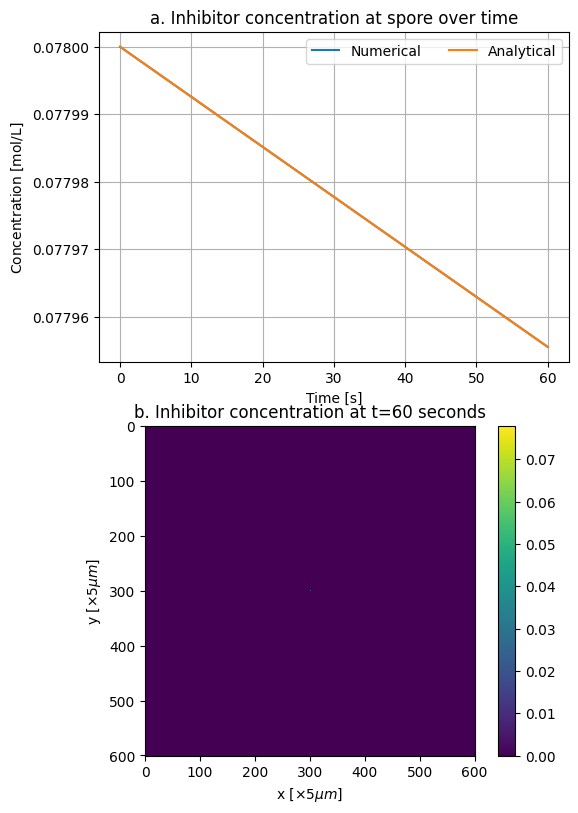

In [31]:
print(f"Thresholds reached at times: {times_thresh}")
print(f"Concentration dropped below {c_thresholds[-1]} at time {times_thresh[-1]}")

c_scale = 0.078
c_analytical_scaled = c_scale * c_analytical
c_evolution_scaled = c_scale * c_evolution

# Compute threshold times analytically
# thresh_times_analytical = time_to_threshold_analytical(c_spore_init, D, spore_vol, 10.0**(-np.arange(1, 7)))

# Plot the concentration evolution
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].plot(times, c_evolution_scaled[:, spore_idx[0], spore_idx[1]], label='Numerical')
axs[0].plot(times, c_analytical_scaled, label='Analytical')
for i, time_thresh in enumerate(times_thresh):
    dash_length = (i + 1)
    if time_thresh > 0:
        axs[0].axvline(x=time_thresh, color='c', dashes=(dash_length, dash_length), linewidth=2, label='$k=10^{'+str(-i-1)+'}$')
# for i, time_thresh in enumerate(thresh_times_analytical):
#     dash_length = (i + 1)
#     if time_thresh > 0:
#         axs[0].axvline(x=time_thresh, color='brown', dashes=(dash_length, dash_length), label='$k=10^{'+str(-i-1)+'}$ (analytical)')
# axs[0].set_ylim(0, c_scale+0.01)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
axs[0].set_title('a. Inhibitor concentration at spore over time')
axs[0].legend(loc='upper right', ncol=2)
axs[0].grid()
fig.tight_layout()

# Plot final concentrations on lattice
img = axs[1].imshow(c_evolution_scaled[-1], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\\mu m$]')
axs[1].set_title(f'b. Inhibitor concentration at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])

## 5. Discussion

There is a perfect alignment between the numerical and the analytical solutions. The thresholds of orders of $O(10^{-n})$ are never reached within the four hours. This suggests the following issues:
- the diffusion constant $D_m$ through biological membranes is actually higher than the one with regard to artificial lipid bilayers;
- the threshold for the inhibitor is actually higher than 0.1 of the initial concentration;
- dimensionality plays a role.

## References

- [1] W. Shinoda, “Permeability across lipid membranes.,” Biochimica et biophysica acta, vol. 1858 10, pp. 2254–2265, 2016.
- [2] P. C. Nelson, M. Radosavljevic, and S. Bromberg, “Biological Physics: Energy, Information, Life,” 2003.
- [3] M. F. Mazzobre, M. Román, A. F. Mourelle, and H. R. Corti, “Octanol-water partition coefficient of glucose, sucrose, and trehalose.,” Carbohydrate research, vol. 340 6, pp. 1207–11, 2005.
- [4] R. Milo and R. Phillips, “Cell Biology by the Numbers,” 2015.
- [5] L. D. Fernando et al., “Structural adaptation of fungal cell wall in hypersaline environment,” Nature Communications, vol. 14, 2023.